# PS Parallel Programming / Sheet 05
# Fabio Valentini / MN 01018782

In [1]:
# initial setup

import subprocess

from IPython.display import HTML, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse

%matplotlib inline
set_matplotlib_formats('svg')

SAMPLE_SIZE = 10
THREADS = 16

## Exercise 1: Computing Delannoy-Numbers

- sequential program: `./delannoy/delannoy_seq.c`
- parallel recursive program: `./delannoy/delannoy_par.c`

### Implementation details

- for the sequential implementation, the formula for the "closed form" of the Delannoy number was implemented
- for the parallel implementation, the task was to use OpenMP Tasks, which only makes sense when implementing the recurrence formula

### Parallelization Bottlenecks

When trying to parallelize the implementation of the "closed form" (for example, by parallelizing the for loops for the sum and the factorial, and using reductions), the overhead of spawning threads was always bigger than any potential gains.

Parallelizing the recursive implementation seems to bottleneck around the creation of many very small tasks. Additionally, many of those recursive calls are redundant since they are called with the same arguments over and over again in different branches of the recursion tree.

### Local performance measurements

In [2]:
parser = parse.Parser("result: {result}, time: {time:.8f} seconds")

sequentials = []

# run sequential delannoy-number calculation
for i in range(SAMPLE_SIZE):
    ret = subprocess.run(["./delannoy/delannoy_seq", str(20)], stdout=subprocess.PIPE)
    sequentials.append(parser.parse(ret.stdout.decode())["time"])

sequentials_fastest = np.array(sequentials).min()

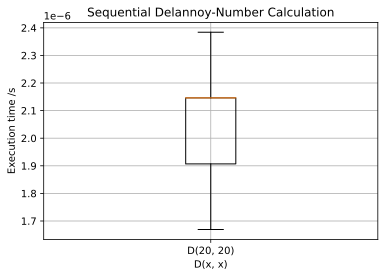

In [3]:
plt.boxplot([sequentials], labels=["D(20, 20)"])

plt.title("Sequential Delannoy-Number Calculation")
plt.xlabel("D(x, x)")
plt.ylabel("Execution time /s")

plt.grid()
plt.show()

In [4]:
parallels = []

threads = [1, 2, 3, 4]

# run parallelized recursive delannoy-number implementation
for p in threads:
    ret = subprocess.run(
        ["./delannoy/delannoy_par_rec", str(12)],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    parallels.append(parser.parse(ret.stdout.decode())["time"])

speedups = sequentials_fastest / parallels

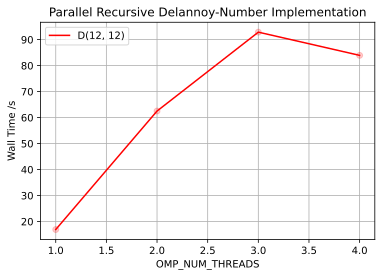

In [5]:
plt.plot(threads, parallels, "ro", alpha=0.2)
plt.plot(threads, parallels, "r-", label="D(12, 12)")

plt.title("Parallel Recursive Delannoy-Number Implementation")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Wall Time /s")

plt.legend()
plt.grid()
plt.show()

It is obvious that the recursive algorithm is very bad compared to the one based on the "closed form". It gets worse with more threads (high overhead of threads compared to very small work items), and even with one thread, calculating `D(12, 12)` recursively is 6-7 orders of magnitude (!) slower than calculating `D(20,20)` with the sequential algorithm!

### LCC2 Performance Measurements

`return ENOTIME`